In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [3]:
import wrds

db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [4]:
# list all libraries available
# db.list_libraries()

In [5]:
# List Compustat annual table columns
cols = db.describe_table('comp', 'funda')
display(cols)

Approximately 929075 rows in comp.funda.


,name,nullable,type,comment
0,gvkey,True,VARCHAR(6),Global Company Key
1,datadate,True,DATE,Data Date
2,fyear,True,INTEGER,Data Year - Fiscal
3,indfmt,True,VARCHAR(12),Industry Format
4,consol,True,VARCHAR(2),Level of Consolidation - Company Annual Descri...
...,...,...,...,...
943,au,True,VARCHAR(8),Auditor
944,auop,True,VARCHAR(8),Auditor Opinion
945,auopic,True,VARCHAR(1),Auditor Opinion - Internal Control
946,ceoso,True,VARCHAR(1),Chief Executive Officer SOX Certification


In [6]:
# save complete list of variables to csv
cols.to_csv('../data/compustat_funda_columns.csv', index=False)


In [7]:
# see all tables in the compustat library
# db.list_tables("comp")

In [8]:
# return structure of compustat annual fundamentals table
db.describe_table("comp", "funda")


Approximately 929075 rows in comp.funda.


,name,nullable,type,comment
0,gvkey,True,VARCHAR(6),Global Company Key
1,datadate,True,DATE,Data Date
2,fyear,True,INTEGER,Data Year - Fiscal
3,indfmt,True,VARCHAR(12),Industry Format
4,consol,True,VARCHAR(2),Level of Consolidation - Company Annual Descri...
...,...,...,...,...
943,au,True,VARCHAR(8),Auditor
944,auop,True,VARCHAR(8),Auditor Opinion
945,auopic,True,VARCHAR(1),Auditor Opinion - Internal Control
946,ceoso,True,VARCHAR(1),Chief Executive Officer SOX Certification


# 1. Compustat annual fundamentals data

In [ ]:
# pull compustat annual fundamentals data from 1951 onward

# Sample restrictions:
#   - datafmt = 'STD' : standardised Compustat data
#   - popsrc  = 'D'   : domestic (U.S.) firms
#   - consol  = 'C'   : consolidated financial statements

# Variables retrieved include:
#   - Firm identifiers: gvkey, company name (conm), ticker (tic)
#   - Time identifiers: datadate (statement date), fyear (fiscal year)
#   - Industry classification: historical NAICS code (naicsh)
#   - Income statement items: revenue (revt), cost of goods sold (cogs),earnings before interest and taxes (ebit), operating income
#     before depreciation (oibdp), retained earnings (re), net income (ni), interest
#     expense (xint), depreciation (dp)
#   - Balance sheet items: total assets (at), current assets (act),
#     cash and short-term investments (che), receivables (rect), inventory (invt), total liabilities (lt),
#     current liabilities (lct), short-term debt (dlc), long-term
#     debt (dltt), common equity (ceq), shares outstanding (csho)
#   - Cash flow items: operating cash flow (oancf), capital expenditure (capx), financing cash flow (fincf), net cash flow from investing (ivncf)
#   - Payouts: dividends (dv)
#   - Prices: share price at fiscal year end (prcc_f)
#   - Adjustment factor to adjust for stock splits/dividends (ajex)


annual = db.raw_sql("""
SELECT
  gvkey, datadate, fyear, conm, tic,
  naicsh,
  revt, cogs, ebit, oibdp, re, ni, xint, dp,
  at, act, che, rect, invt, lt, lct, dlc, dltt, ceq, csho,
  oancf, capx, fincf, ivncf,
  dv,
  prcc_f
FROM comp.funda
WHERE datafmt='STD'
  AND popsrc='D' 
  AND consol='C'
  AND fyear >= 1951
""")


In [10]:
annual.head()


,gvkey,datadate,fyear,conm,tic,naicsh,revt,cogs,ebit,oibdp,...,dlc,dltt,ceq,csho,oancf,capx,fincf,ivncf,dv,prcc_f
0,001000,1961-12-31,1961,A & E PLASTIK PAK INC,AE.2,<NA>,0.9,<NA>,<NA>,<NA>,...,<NA>,0.1,<NA>,0.152,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,001000,1962-12-31,1962,A & E PLASTIK PAK INC,AE.2,<NA>,1.6,<NA>,<NA>,<NA>,...,<NA>,0.0,0.552,0.181,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,001000,1963-12-31,1963,A & E PLASTIK PAK INC,AE.2,<NA>,1.457,1.065,0.0,0.046,...,<NA>,0.015,0.553,0.186,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,001000,1964-12-31,1964,A & E PLASTIK PAK INC,AE.2,<NA>,2.032,1.474,0.074,0.127,...,0.088,0.522,0.607,0.196,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,001000,1965-12-31,1965,A & E PLASTIK PAK INC,AE.2,<NA>,1.688,1.342,-0.242,-0.16,...,0.3,1.154,0.491,0.206,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [11]:
# convert to datetime object
annual['datadate'] = pd.to_datetime(annual['datadate'])


In [12]:
# convert compustat annual data to csv
annual.to_csv(
    "../data/raw/compustat_annual_1951_onward.csv",
    index=False
)


In [13]:
# test CRSP data pull

crsp_test = db.raw_sql("""
SELECT permno, date, ret, prc, shrout
FROM crsp.dsf
WHERE date BETWEEN '2019-01-01' AND '2019-01-31'
LIMIT 100
""")

crsp_test.head()


,permno,date,ret,prc,shrout
0,10026,2019-01-02,-0.024829,141.0,18774.0
1,10028,2019-01-02,-0.043488,0.4399,26924.0
2,10032,2019-01-02,0.012921,51.74,30992.0
3,10044,2019-01-02,0.012887,8.63,5949.0
4,10066,2019-01-02,<NA>,<NA>,43809.0


# 2. CRSP daily stock price data

In [14]:
# pull CRSP daily stock file data from 1951 onward, year by year, and save to compressed csv
# Variables retrieved:
#   - permno : Permanent firm identifier
#   - date   : Trading date
#   - ret    : Daily stock return
#   - prc    : Daily closing price
#   - shrout : Shares outstanding (in thousands)

'''
out_path = "crsp_dsf_1951_onward.csv.gz"
first = True # header writing for first year only

for y in range(1951, 2025):
    # define start and end date for calendar year
    start = f"{y}-01-01"
    end   = f"{y}-12-31"

    # pull CRSP daily data for the year
    chunk = db.raw_sql(f"""
        SELECT permno, date, ret, prc, shrout
        FROM crsp.dsf
        WHERE date BETWEEN '{start}' AND '{end}'
    """)

    # append to compressed csv with headers for first year only
    chunk.to_csv(
        out_path,
        mode="wt" if first else "at",
        header=first,
        index=False,
        compression="gzip"
    )

    first = False
    
    # print progress information
    print("wrote year", y, "rows", len(chunk))
    
'''

'\nout_path = "crsp_dsf_1951_onward.csv.gz"\nfirst = True # header writing for first year only\n\nfor y in range(1951, 2025):\n    # define start and end date for calendar year\n    start = f"{y}-01-01"\n    end   = f"{y}-12-31"\n\n    # pull CRSP daily data for the year\n    chunk = db.raw_sql(f"""\n        SELECT permno, date, ret, prc, shrout\n        FROM crsp.dsf\n        WHERE date BETWEEN \'{start}\' AND \'{end}\'\n    """)\n\n    # append to compressed csv with headers for first year only\n    chunk.to_csv(\n        out_path,\n        mode="wt" if first else "at",\n        header=first,\n        index=False,\n        compression="gzip"\n    )\n\n    first = False\n    \n    # print progress information\n    print("wrote year", y, "rows", len(chunk))\n    \n'

In [15]:
# verify crsp output by reading a few rows
test = pd.read_csv(
    "crsp_dsf_1951_onward.csv.gz",
    compression="gzip",
    nrows=5
)

test


FileNotFoundError: [Errno 2] No such file or directory: 'crsp_dsf_1951_onward.csv.gz'

# 3. Compustat bankruptcy data

In [ ]:
# view structure of compustat annual footnote and datacode table
# table contains footnote flags used to identify conditions including bankruptcy
cols = db.describe_table('comp', 'funda_fncd')
display(cols)



Approximately 928103 rows in comp.funda_fncd.


,name,nullable,type,comment
0,gvkey,True,VARCHAR(6),Global Company Key
1,datadate,True,DATE,Data Date
2,fyear,True,INTEGER,Data Year - Fiscal
3,indfmt,True,VARCHAR(12),Industry Format
4,consol,True,VARCHAR(2),Level of Consolidation - Company Annual Descri...
...,...,...,...,...
882,xuw_dc,True,SMALLINT,Other Underwriting Expenses - Insurance Data Code
883,xuwli_dc,True,SMALLINT,Underwriting Expense - Life Data Code
884,xuwnli_dc,True,SMALLINT,Underwriting Expense - Non-Life Data Code
885,xuwoi_dc,True,SMALLINT,Underwriting Expense - Other Data Code


In [ ]:
# pull total assets footnote flag from compustat annual footnote and datacode table
# key variable retrieved:
#   - at_fn : Assets footnote indicator, which contains codes like 'TL' denoting bankruptcy or liquidation status as defined by Compustat.

fn = db.raw_sql("""
    SELECT gvkey, datadate, fyear, at_fn
    FROM comp.funda_fncd
    WHERE fyear >= 1951
""")

# save footnote data to compressed CSV file
fn.to_csv("comp_funda_fncd_at_fn_1951_onward.csv.gz",
          index=False, compression="gzip")

In [ ]:
# merge compustat annual data with footnote data to add bankruptcy flag using firm identifier (gvkey) and statement date (datadate)

annual["datadate"] = pd.to_datetime(annual["datadate"])
fn["datadate"] = pd.to_datetime(fn["datadate"])

annual = annual.merge(
    fn[["gvkey", "datadate", "at_fn"]],
    on=["gvkey", "datadate"],
    how="left"
)

# construct bankruptcy/liquidation flag based on presence of 'TL' in at_fn footnote indicator
annual["TL_flag"] = annual["at_fn"].astype(str).str.contains("TL", na=False).astype(int)


In [ ]:
annual.head()

,gvkey,datadate,fyear,conm,tic,naicsh,revt,cogs,ebit,oibdp,...,ceq,csho,oancf,capx,fincf,ivncf,dv,prcc_f,at_fn,TL_flag
0,001000,1961-12-31,1961,A & E PLASTIK PAK INC,AE.2,<NA>,0.9,<NA>,<NA>,<NA>,...,<NA>,0.152,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
1,001000,1962-12-31,1962,A & E PLASTIK PAK INC,AE.2,<NA>,1.6,<NA>,<NA>,<NA>,...,0.552,0.181,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
2,001000,1963-12-31,1963,A & E PLASTIK PAK INC,AE.2,<NA>,1.457,1.065,0.0,0.046,...,0.553,0.186,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
3,001000,1964-12-31,1964,A & E PLASTIK PAK INC,AE.2,<NA>,2.032,1.474,0.074,0.127,...,0.607,0.196,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
4,001000,1965-12-31,1965,A & E PLASTIK PAK INC,AE.2,<NA>,1.688,1.342,-0.242,-0.16,...,0.491,0.206,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0


In [ ]:
# save updated Compustat annual dataset
annual.to_csv(
    "../data/raw/compustat_annual_1951_onward.csv",
    index=False
)


In [ ]:
# inspect number of bankruptcy firm-years
annual["TL_flag"].value_counts()



TL_flag
0    1026808
1       1945
Name: count, dtype: int64

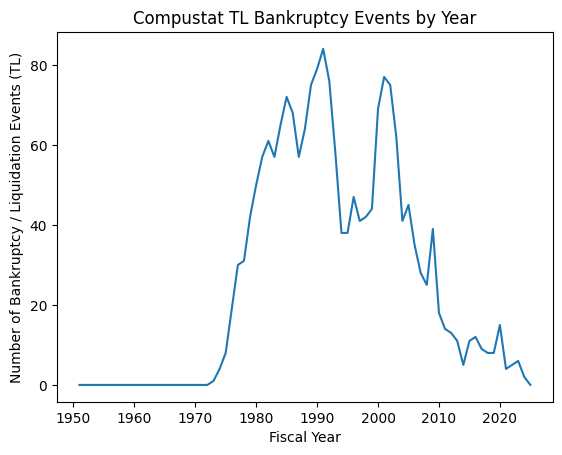

In [ ]:
# bankruptcy counts by year
annual.groupby("fyear")["TL_flag"].sum()

# Aggregate bankruptcies by year
tl_by_year = annual.groupby("fyear")["TL_flag"].sum()

# Plot
plt.figure()
plt.plot(tl_by_year.index, tl_by_year.values)
plt.xlabel("Fiscal Year")
plt.ylabel("Number of Bankruptcy / Liquidation Events (TL)")
plt.title("Compustat TL Bankruptcy Events by Year")
plt.show()



In [ ]:
# number of unique firms that have filed for bankruptcy/liquidation
annual.loc[annual["TL_flag"] == 1, "gvkey"].nunique()


1003